In [1]:
import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

print(tf.__version__)

2.3.0


In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
plt.style.use('ggplot')
%matplotlib inline 

In [3]:
img_width = 64
img_height = 64 

In [4]:
datagen = ImageDataGenerator(rescale = 1/255.0, validation_split = 0.2)


In [5]:
train_data_generator = datagen.flow_from_directory(directory = './data/train/',
                                                   target_size = (img_width, img_height),
                                                   class_mode = 'binary',
                                                   batch_size = 16, 
                                                   subset = 'training'
)

Found 17638 images belonging to 2 classes.


In [6]:
validation_data_generator = datagen.flow_from_directory(directory = './data/val/',
                                                   target_size = (img_width, img_height),
                                                   class_mode = 'binary',
                                                   batch_size = 16, 
                                                   subset = 'validation'
)

Found 550 images belonging to 2 classes.


In [7]:
test_data_generator = datagen.flow_from_directory(directory = './data/test/',
                                                  target_size = (img_width,img_height),
                                                  class_mode = 'binary',
                                                  batch_size = 1,
                                                  shuffle = False)

Found 2758 images belonging to 2 classes.


In [8]:
model = Sequential()

model.add(Conv2D(16, (3,3), input_shape = (img_width,img_height,3), activation = 'relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [9]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [10]:
from tensorflow.keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [11]:
history = model.fit_generator(generator = train_data_generator,
                              steps_per_epoch = len(train_data_generator),
                              epochs = 25,
                              validation_data = validation_data_generator,
                              validation_steps = len(validation_data_generator),
                              callbacks = [earlystopping])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
1103/1103 [==============================] - 94s 85ms/step - loss: 0.5462 - accuracy: 0.7252 - val_loss: 0.4246 - val_accuracy: 0.8855
Epoch 2/25
1103/1103 [==============================] - 21s 19ms/step - loss: 0.2891 - accuracy: 0.9117 - val_loss: 0.2156 - val_accuracy: 0.9127
Epoch 3/25
1103/1103 [==============================] - 21s 19ms/step - loss: 0.2041 - accuracy: 0.9287 - val_loss: 0.1716 - val_accuracy: 0.9273
Epoch 4/25
1103/1103 [==============================] - 22s 20ms/step - loss: 0.1826 - accuracy: 0.9342 - val_loss: 0.1666 - val_accuracy: 0.9455
Epoch 5/25
1103/1103 [==============================] - 22s 20ms/step - loss: 0.1742 - accuracy: 0.9438 - val_loss: 0.1720 - val_accuracy: 0.9473
Epoch 6/25
1103/1103 [==============================] - 21s 19ms/step - loss: 0.1658 - accuracy: 0.9489 - val_loss: 0.1735 - val_accuracy: 0.9509
Epoch 7/25
1103/1103 [==========================

In [14]:
def plot_learningCurve(model, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, model.history['accuracy'])
  plt.plot(epoch_range, model.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, model.history['loss'])
  plt.plot(epoch_range, model.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

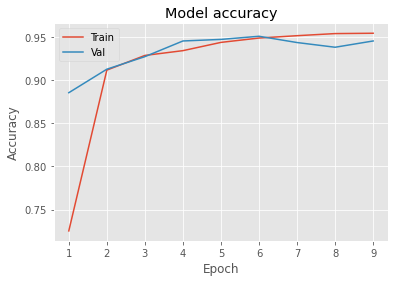

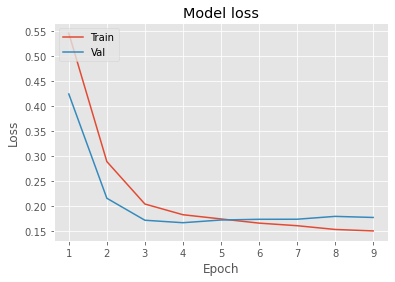

In [16]:
plot_learningCurve(history, 9)

# Testing 

In [17]:
steps_valid = validation_data_generator.n//validation_data_generator.batch_size

In [18]:
model.evaluate_generator(generator=validation_data_generator, steps = steps_valid)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.1669689267873764, 0.9448529481887817]

In [19]:
steps_test = test_data_generator.n//test_data_generator.batch_size
test_data_generator.reset()
pred = model.predict_generator(test_data_generator, steps = steps_test,verbose = 1)

Instructions for updating:
Please use Model.predict, which supports generators.
2758/2758 [==============================] - 15s 5ms/step


In [20]:
pred_class_indices = np.around(pred)
pred_class_indices = pred_class_indices.flatten()

In [21]:
labels = (train_data_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in (pred_class_indices)]
classes = [labels[k] for k in (test_data_generator.classes)]


In [22]:
filenames=test_data_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions,
                      "Actual":classes})

In [23]:
wrong = len(results[results['Predictions'] != results['Actual']])

In [24]:
wrong/len(results)

0.052574329224075414

In [1]:
1 - 0.05257

0.94743

# Confusion Matrix

## minimize recall for disease related stuff

In [30]:
from sklearn.metrics import classification_report, confusion_matrix 

In [34]:
report = classification_report(results.Actual, results.Predictions)
print(report)

              precision    recall  f1-score   support

 Parasitized       0.96      0.94      0.95      1379
  Uninfected       0.94      0.96      0.95      1379

    accuracy                           0.95      2758
   macro avg       0.95      0.95      0.95      2758
weighted avg       0.95      0.95      0.95      2758



In [35]:
cf = confusion_matrix(results.Actual, results.Predictions)
print(cf)

[[1293   86]
 [  59 1320]]
